In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gstn-hackathon/X_Train_Data_Input_Imputed.csv
/kaggle/input/gstn-hackathon/Y_Train_Data_Target.csv
/kaggle/input/gstn-hackathon/X_Test_Data_Input.csv
/kaggle/input/gstn-hackathon/X_Train_Data_Input.csv
/kaggle/input/gstn-hackathon/X_Test_Data_Input_Imputed.csv
/kaggle/input/gstn-hackathon/Y_Test_Data_Target.csv


In [2]:
X_train = pd.read_csv('/kaggle/input/gstn-hackathon/X_Train_Data_Input_Imputed.csv')
y_train = pd.read_csv('/kaggle/input/gstn-hackathon/Y_Train_Data_Target.csv')
X_test = pd.read_csv('/kaggle/input/gstn-hackathon/X_Test_Data_Input_Imputed.csv')
y_test = pd.read_csv('/kaggle/input/gstn-hackathon/Y_Test_Data_Target.csv')
y_train = y_train.drop('ID', axis=1)
y_test = y_test.drop('ID', axis=1)

In [3]:
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.compose import ColumnTransformer

In [4]:
pt=PowerTransformer(method='yeo-johnson')
scaler = RobustScaler()

In [5]:
skewed_columns = ['Column3', 'Column4', 'Column5', 'Column6', 'Column7', 'Column10', 'Column11']
scaled_columns = ['Column3', 'Column4', 'Column5', 'Column6', 'Column7', 'Column10', 'Column11']

In [6]:
preprocessing_pipeline = ColumnTransformer([
    ('pt', pt, skewed_columns),
    ('scaler', scaler, scaled_columns)
], remainder='passthrough')

In [ ]:
preprocessing_pipeline_2 = ColumnTransformer([
    ('pt', pt, skewed_columns),
    ('scaler', scaler, scaled_columns)
], remainder='passthrough')

In [7]:
X_train_scaled = preprocessing_pipeline.fit_transform(X_train)
X_test_scaled = preprocessing_pipeline.transform(X_test)

In [8]:
X_train_scaled = pd.DataFrame(X_train_scaled)
X_test_scaled = pd.DataFrame(X_test_scaled)

In [9]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [10]:
from sklearn.preprocessing import PolynomialFeatures
Poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly_train = Poly.fit_transform(X_train_scaled)
X_poly_test = Poly.fit_transform(X_test_scaled)
X_poly_train = pd.DataFrame(X_poly_train)
X_poly_test = pd.DataFrame(X_poly_test)
print(X_poly_train.shape)
print(X_poly_test.shape)

(785133, 434)
(261712, 434)


In [11]:
selector = SelectKBest(mutual_info_classif, k=50)
X_train_selected = selector.fit_transform(X_poly_train, y_train)
X_test_selected = selector.transform(X_poly_test)
X_train_selected = pd.DataFrame(X_train_selected)
X_test_selected = pd.DataFrame(X_test_selected)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0  0.9940526799 0.9815596075 0.9877666428    237034
           1  0.8419568283 0.9435934841 0.8898824878     24678

    accuracy                      0.9779796112    261712
   macro avg  0.9180047541 0.9625765458 0.9388245653    261712
weighted avg  0.9797108789 0.9779796112 0.9785367062    261712

ROC AUC Score: 0.9945362971838076


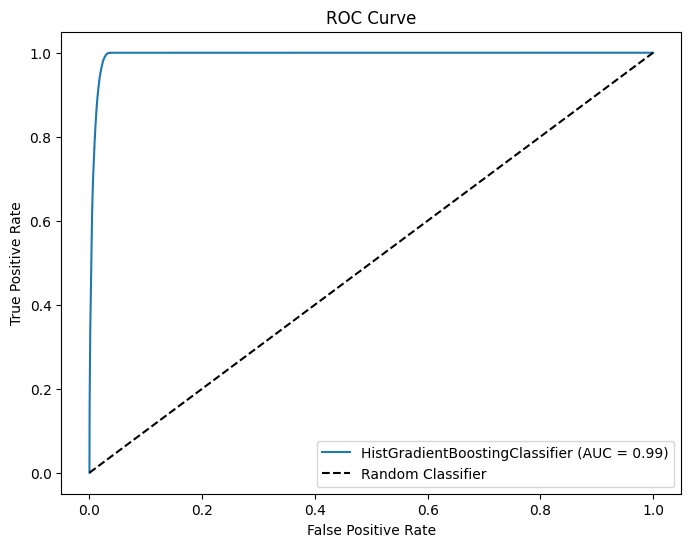

Optimal Threshold: 0.11700395082022719


In [12]:
hgb_classifier = HistGradientBoostingClassifier(random_state=42)
hgb_classifier.fit(X_train_selected, y_train)

# Step 8: Model Evaluation
# Predictions and evaluation
y_pred = hgb_classifier.predict(X_test_selected)
y_pred_proba = hgb_classifier.predict_proba(X_test_selected)[:, 1]

# Calculate classification report
print(classification_report(y_test, y_pred, digits=10))

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc}")

# Plot the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'HistGradientBoostingClassifier (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# Step 9: Determine Optimal Threshold
# Return the optimal threshold that maximizes the ROC curve
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f'Optimal Threshold: {optimal_threshold}')

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 74033, number of negative: 711100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.253786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8785
[LightGBM] [Info] Number of data points in the train set: 785133, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.094294 -> initscore=-2.262302
[LightGBM] [Info] Start training from score -2.262302
              precision    recall  f1-score   support

           0  0.9941673646 0.9815596075 0.9878232589    237034
           1  0.8421109666 0.9446875760 0.8904549100     24678

    accuracy                      0.9780827780    261712
   macro avg  0.9181391656 0.9631235917 0.9391390845    261712
weighted avg  0.9798292838 0.9780827780 0.9786419600    261712

ROC AUC Score: 0.9945368189355692


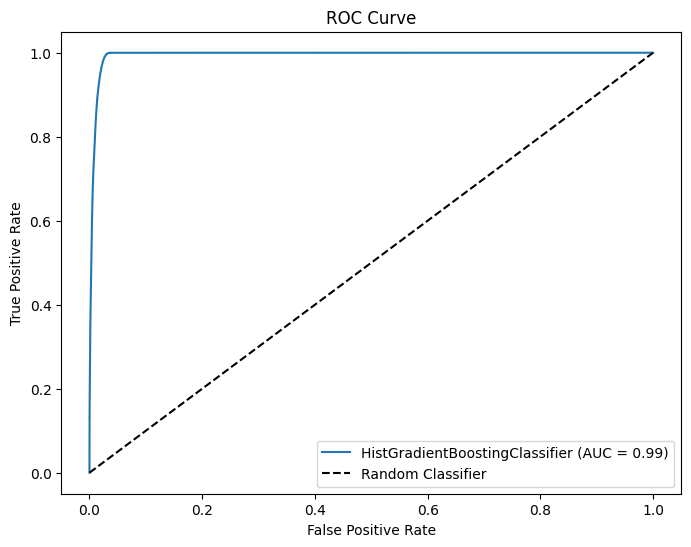

Optimal Threshold: 0.11227838953770031


In [13]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier()
lgb.fit(X_train_selected, y_train)
y_pred_lgb=lgb.predict(X_test_selected)
y_pred_proba_lgb = lgb.predict_proba(X_test_selected)[:, 1]

# Calculate classification report
print(classification_report(y_test, y_pred_lgb, digits=10))

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba_lgb)
print(f"ROC AUC Score: {roc_auc}")

# Plot the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_lgb)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'HistGradientBoostingClassifier (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# Step 9: Determine Optimal Threshold
# Return the optimal threshold that maximizes the ROC curve
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f'Optimal Threshold: {optimal_threshold}')
